<a href="https://colab.research.google.com/github/ikibovad/LiquidityStressTrading/blob/main/LiquidityStressTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  7 of 7 completed
<ipython-input-51-80129a68f913>:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.fillna(False).astype(bool)
<ipython-input-51-80129a68f913>:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp = temp.fillna(False).astype(bool)
<ipython-input-51-80129a68f913>:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd


=== Pre- and Post-COVID Strategy Performance ===
   Ticker      Period  Holding Period (Days)  Number of Trades  \
0     SPY   Pre-COVID                      5                91   
1     SPY   Pre-COVID                     15                91   
2     SPY   Pre-COVID                     30                91   
3     SLV   Pre-COVID                      5               123   
4     SLV   Pre-COVID                     15               123   
5     SLV   Pre-COVID                     30               123   
6     GLD   Pre-COVID                      5               100   
7     GLD   Pre-COVID                     15               100   
8     GLD   Pre-COVID                     30               100   
9     USO   Pre-COVID                      5               104   
10    USO   Pre-COVID                     15               104   
11    USO   Pre-COVID                     30               104   
12   WEAT   Pre-COVID                      5                95   
13   WEAT   Pre-COVID     

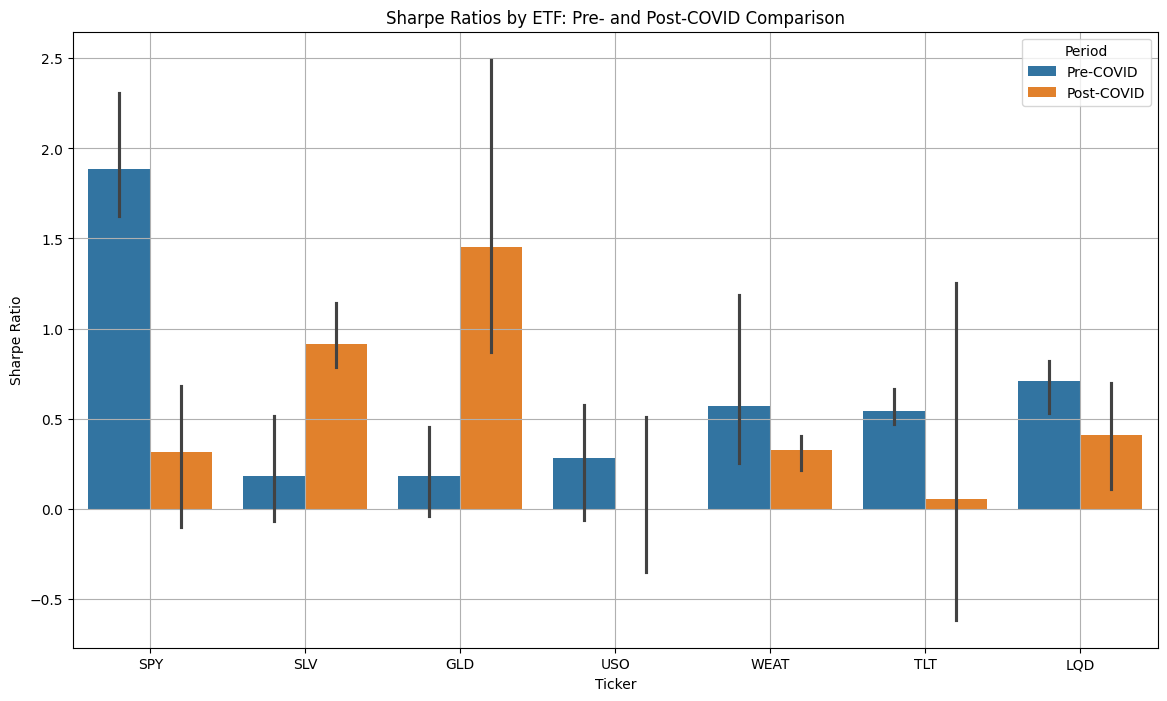

<ipython-input-51-80129a68f913>:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  momentum['Date'] = pd.to_datetime(momentum['Date'], format='%Y%m%d')



=== Pre-COVID Regression Results (Newey-West HAC SE) ===
                            OLS Regression Results                            
Dep. Variable:             Excess_SPY   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 5.687e+04
Date:                Sat, 19 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:51:08   Log-Likelihood:                 15304.
No. Observations:                2555   AIC:                        -3.059e+04
Df Residuals:                    2548   BIC:                        -3.055e+04
Df Model:                           6                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------

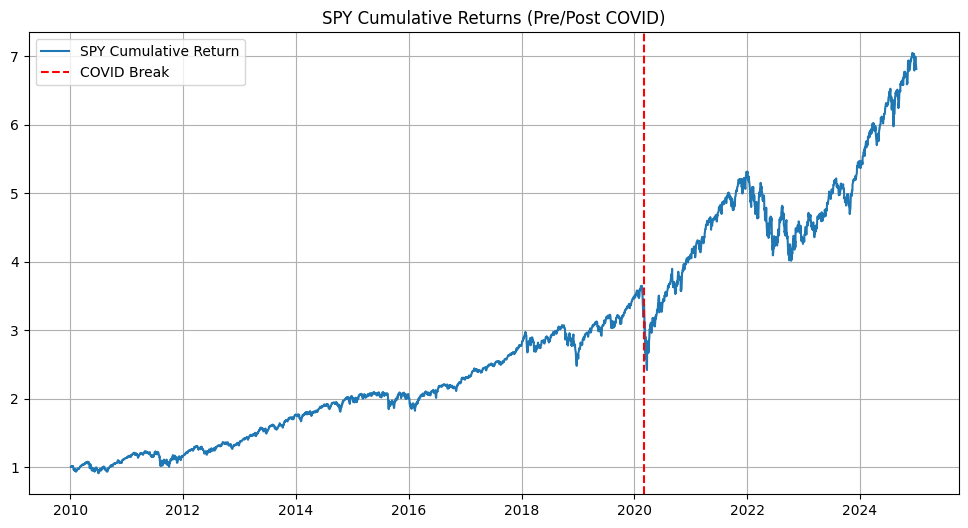

In [51]:
# === Libraries ===
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from sklearn.utils import resample
from statsmodels.stats import sandwich_covariance as sw

# === Step 1: Download ETF Data ===
tickers = ['SPY', 'SLV', 'GLD', 'USO', 'WEAT', 'TLT', 'LQD']
start_date = '2010-01-01'
end_date = '2025-06-30'

data = yf.download(tickers, start=start_date, end=end_date)
close_prices = data['Close']
volumes = data['Volume']

# === Step 2: Amihud Illiquidity Measure ===
returns = close_prices.pct_change().abs()
dollar_volume = close_prices * volumes
amihud_illiq = returns / dollar_volume
amihud_illiq = amihud_illiq.dropna()

# === Step 3: Rolling Stress Detection (Top 5%) ===
rolling_window = 252
rolling_thresholds = amihud_illiq.rolling(window=rolling_window, min_periods=200).quantile(0.95)
stress_days = amihud_illiq > rolling_thresholds
stress_days = stress_days.dropna()

# === Step 4: Clean Stress Signals ===
stress_days_cleaned = {}
for ticker in tickers:
    temp = stress_days.get(ticker, pd.Series(index=close_prices.index, data=False))
    temp = temp.reindex(close_prices.index)
    temp = temp.fillna(False).astype(bool)
    stress_days_cleaned[ticker] = temp
stress_days_cleaned = pd.DataFrame(stress_days_cleaned)

# === Step 5: Trading Strategy (5, 15, 30 day holding periods) ===
holding_periods = [5, 15, 30]
strategy_results = {}

for ticker in tickers:
    strategy_results[ticker] = {}
    price_series = close_prices[ticker]
    signals = stress_days_cleaned[ticker]

    for h in holding_periods:
        df = pd.DataFrame(index=price_series.index)
        df['Signal'] = signals
        df['EntryPrice'] = price_series.shift(-1)
        df['ExitPrice'] = price_series.shift(-1-h)
        df['Return'] = (df['ExitPrice'] - df['EntryPrice']) / df['EntryPrice']
        df = df[df['Signal']].dropna()
        strategy_results[ticker][h] = df

# === Step 6: Split Pre-COVID and Post-COVID ===
pre_covid_end = pd.to_datetime('2019-12-31')
post_covid_start = pd.to_datetime('2020-01-01')

pre_covid_stats = []
post_covid_stats = []

for ticker in tickers:
    for h in holding_periods:
        trades = strategy_results[ticker][h]
        if not trades.empty:
            pre_trades = trades.loc[trades.index <= pre_covid_end]
            post_trades = trades.loc[trades.index >= post_covid_start]

            # Pre-COVID
            if not pre_trades.empty:
                avg_return = pre_trades['Return'].mean()
                win_rate = (pre_trades['Return'] > 0).mean()
                sharpe = (avg_return / pre_trades['Return'].std()) * np.sqrt(252/h)
                pre_covid_stats.append({
                    'Ticker': ticker,
                    'Period': 'Pre-COVID',
                    'Holding Period (Days)': h,
                    'Number of Trades': len(pre_trades),
                    'Average Return (%)': avg_return * 100,
                    'Win Rate (%)': win_rate * 100,
                    'Sharpe Ratio': sharpe
                })

            # Post-COVID
            if not post_trades.empty:
                avg_return = post_trades['Return'].mean()
                win_rate = (post_trades['Return'] > 0).mean()
                sharpe = (avg_return / post_trades['Return'].std()) * np.sqrt(252/h)
                post_covid_stats.append({
                    'Ticker': ticker,
                    'Period': 'Post-COVID',
                    'Holding Period (Days)': h,
                    'Number of Trades': len(post_trades),
                    'Average Return (%)': avg_return * 100,
                    'Win Rate (%)': win_rate * 100,
                    'Sharpe Ratio': sharpe
                })

# === Step 7: Display Strategy Results ===
summary_df = pd.DataFrame(pre_covid_stats + post_covid_stats)
print("\n=== Pre- and Post-COVID Strategy Performance ===")
print(summary_df)

# === Step 8: Optional Plotting of Sharpe Ratios ===
plt.figure(figsize=(14,8))
sns.barplot(data=summary_df, x='Ticker', y='Sharpe Ratio', hue='Period')
plt.title('Sharpe Ratios by ETF: Pre- and Post-COVID Comparison')
plt.grid(True)
plt.show()

# === Step 9: Fama-French 5-Factor + Momentum Regressions ===

# Load Fama-French 5-Factor Daily Data
ff5 = pd.read_csv('/content/F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3)
ff5 = ff5.rename(columns={'Unnamed: 0': 'Date'})
ff5 = ff5[ff5['Date'].astype(str).str.len() == 8]
ff5['Date'] = pd.to_datetime(ff5['Date'], format='%Y%m%d')
ff5 = ff5.set_index('Date')
ff5 = ff5 / 100  # Convert percentages to decimals

# Load Momentum Factor
momentum = pd.read_csv('/content/F-F_Momentum_Factor_daily.CSV', skiprows=13)
momentum.columns = ['Date', 'Mom']
momentum = momentum[momentum['Date'].astype(str).str.len() == 8]
momentum['Date'] = pd.to_datetime(momentum['Date'], format='%Y%m%d')
momentum = momentum.set_index('Date')
momentum = momentum / 100  # Convert to decimals

# Merge Factors
full_factors = ff5.copy()
full_factors['Mom'] = momentum['Mom']

# Merge with SPY Returns
spy_returns = close_prices['SPY'].pct_change().dropna()
merged_data = spy_returns.to_frame(name='SPY_Return').merge(full_factors, left_index=True, right_index=True, how='inner')
merged_data['Excess_SPY'] = merged_data['SPY_Return'] - merged_data['RF']

# Define Pre-COVID and Post-COVID periods
pre_covid = merged_data.loc[merged_data.index < '2020-03-01']
post_covid = merged_data.loc[merged_data.index >= '2020-03-01']

# Regression Function
def run_ff_regression(data_subset, label):
    X = data_subset[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'Mom']]
    X = sm.add_constant(X)
    y = data_subset['Excess_SPY']

    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':5})

    print(f"\n=== {label} Regression Results (Newey-West HAC SE) ===")
    print(model.summary())

# Run Regressions
run_ff_regression(pre_covid, 'Pre-COVID')
run_ff_regression(post_covid, 'Post-COVID')
run_ff_regression(merged_data, 'Full Sample')

# === Step 10: Optional Plot of SPY Cumulative Returns ===
cumulative_returns = (1 + merged_data['SPY_Return']).cumprod()
plt.figure(figsize=(12,6))
plt.plot(cumulative_returns, label='SPY Cumulative Return')
plt.axvline(pd.Timestamp('2020-03-01'), color='red', linestyle='--', label='COVID Break')
plt.legend()
plt.title('SPY Cumulative Returns (Pre/Post COVID)')
plt.grid(True)
plt.show()
